In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
from PIL import Image, ImageOps
import time
import torch.nn as nn
# %matplotlib inline
import os
import torch
from torch.autograd import Variable
import math
dtype = torch.cuda.FloatTensor

In [29]:
class Concat(nn.Module):
    def __init__(self, dim, skip, deeper):
        super(Concat, self).__init__()
        self.dim = dim
        self.layer1 = skip
        self.layer2 = deeper
    def forward(self, input):
        inputs = []
        inputs.append(self.layer1(input))
        inputs.append(self.layer2(input))
        return torch.cat(inputs, dim=self.dim)

def get_name(name):
    name[0] +=1
    return str(name[0])

def skip(c_in, c_out, c_down, c_up, c_skip, k_down, k_up, k_skip, upsample_mode):
    model = nn.Sequential()
    model_tmp = model
    input_depth = c_in
    name = [0]
    for i in range(len(c_down)):
        layer = nn.Sequential()
        layer.add_module(get_name(name),nn.Conv2d(input_depth, c_down[i], k_down, 2, padding=int((k_down - 1) / 2)))
        layer.add_module(get_name(name),nn.BatchNorm2d(c_down[i]))
        layer.add_module(get_name(name),nn.LeakyReLU(0.2, inplace=True))

        layer.add_module(get_name(name),nn.Conv2d(c_down[i], c_down[i], k_down, 1, padding=int((k_down - 1) / 2)))
        layer.add_module(get_name(name),nn.BatchNorm2d(c_down[i]))
        layer.add_module(get_name(name),nn.LeakyReLU(0.2, inplace=True))

        deeper_main = nn.Sequential()
        
        if i < len(c_down)-1:
            layer.add_module(get_name(name),deeper_main)
            layer.add_module(get_name(name),nn.Upsample(scale_factor=2, mode=upsample_mode))
            if c_skip[i] != 0:
                concat_layers = []
                concat_layers.append(nn.Conv2d(input_depth, c_skip[i], k_skip, 1, padding=int((k_skip - 1) / 2)))
                concat_layers.append(nn.BatchNorm2d(c_skip[i]))
                concat_layers.append(nn.LeakyReLU(0.2, inplace=True))
                model_tmp.add_module(get_name(name),Concat(1, nn.Sequential(*concat_layers), layer))
            else:
                model_tmp.add_module(get_name(name),layer)
            model_tmp.add_module(get_name(name),nn.BatchNorm2d(c_skip[i] + c_up[i + 1] ))
            model_tmp.add_module(get_name(name),nn.Conv2d(c_skip[i] + c_up[i + 1], c_up[i], k_up, 1, padding=int((k_up - 1) / 2)))
            
        else:#last layer
            layer.add_module(get_name(name),nn.Upsample(scale_factor=2, mode=upsample_mode))
            if c_skip[i] != 0:
                concat_layers = []
                concat_layers.append(nn.Conv2d(input_depth, c_skip[i], k_skip, 1, padding=int((k_skip - 1) / 2)))
                concat_layers.append(nn.BatchNorm2d(c_skip[i]))
                concat_layers.append(nn.LeakyReLU(0.2, inplace=True))
                model_tmp.add_module(get_name(name),Concat(1, nn.Sequential(*concat_layers), layer))
            else:
                model_tmp.add_module(get_name(name),layer)
            model_tmp.add_module(get_name(name),nn.BatchNorm2d(c_skip[i] +c_down[i]))
            model_tmp.add_module(get_name(name),nn.Conv2d(c_skip[i] + c_down[i], c_up[i], k_up, 1, padding=int((k_up - 1) / 2)))

        model_tmp.add_module(get_name(name),nn.BatchNorm2d(c_up[i]))
        model_tmp.add_module(get_name(name),nn.LeakyReLU(0.2, inplace=True))
        model_tmp.add_module(get_name(name),nn.Conv2d(c_up[i], c_up[i], 1, 1))
        model_tmp.add_module(get_name(name),nn.BatchNorm2d(c_up[i]))
        model_tmp.add_module(get_name(name),nn.LeakyReLU(0.2, inplace=True))
        input_depth = c_down[i]
        model_tmp = deeper_main

    model.add_module(get_name(name),nn.Conv2d(c_up[0], c_out, 1, 1))
    model.add_module(get_name(name),nn.Sigmoid())

    return model

In [16]:
def preprocess_input_with_mask(img, mask):
    img = Image.open(img)
#     img.resize((512,512), Image.ANTIALIAS)
    img = ImageOps.fit(img, (512,512), Image.ANTIALIAS)
    plt.imshow(img)
    mask = Image.open(mask)
    plt.figure()
    plt.imshow(mask,cmap='gray')
    img = np.array(img).transpose(2,0,1)
    print(img.shape)
    img = img[:3,:512,:512]/255
    mask = np.array(mask)[None, :]/255
    processed_img = img*mask
    plt.figure()
    plt.imshow(processed_img.transpose(1,2,0))
    img = (torch.from_numpy(img)[None,:]).type(dtype)
    mask = (torch.from_numpy(mask)[None,:]).type(dtype)
    processed_img = (torch.from_numpy(processed_img)[None,:]).type(dtype)
    return img, mask, processed_img 

In [17]:
def preprocess_input(img):
    img = Image.open(img)
#     img.resize((512,512), Image.ANTIALIAS)
    img = ImageOps.fit(img, (512,512), Image.ANTIALIAS)
    plt.imshow(img)
    img = np.array(img)
    print(img.shape)
    
    tmp = np.random.choice(512*512, 512*512//2)
    processed_img = img.copy()
    
    if len(img.shape)<3:
        
        img = img[:512,:512]/255
        mask = np.ones((512,512))
        for i in tmp:
            mask[i//512,i%512] = 0
        plt.figure()
        plt.imshow(mask, cmap='gray')
        
        processed_img = img*mask
        
        plt.figure()
        plt.imshow(processed_img)
        
    else:
        img = np.array(img).transpose(2,0,1)
        img = img[:3,:512,:512]/255
        mask = np.ones((3,512,512))
        for i in tmp:
            mask[:,i//512,i%512] = 0
        plt.figure()
        plt.imshow(mask.transpose(1,2,0))
        
        processed_img = img*mask
    
        plt.figure()
        plt.imshow(processed_img.transpose(1,2,0))

    mask = (torch.from_numpy(mask)[None,:]).type(dtype)
    processed_img = (torch.from_numpy(processed_img)[None,:]).type(dtype)
    return mask, processed_img 

(512, 512, 3)


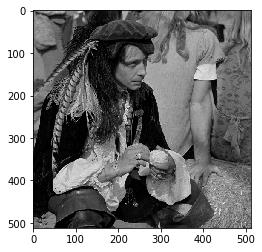

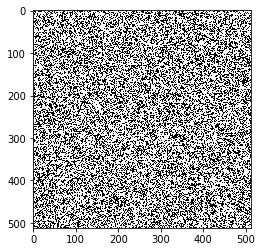

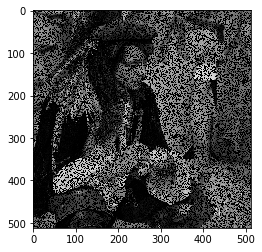

In [26]:
base_dir = 'inpainting_dataset/'
img = base_dir+'Set14/man.png'
# mask = base_dir+'justin_mask.png'
mask, processed_img = preprocess_input(img)

Op time: 0.112634
Iteration 00000  Loss 0.054460  PSNR 12.639200
3


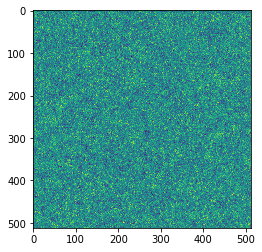

Op time: 10.197487
Iteration 00100  Loss 0.006882  PSNR 21.622793
3


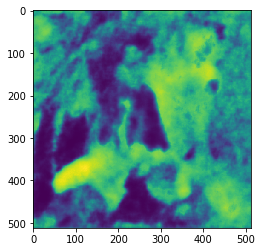

Op time: 20.250632
Iteration 00200  Loss 0.004171  PSNR 23.797734
3


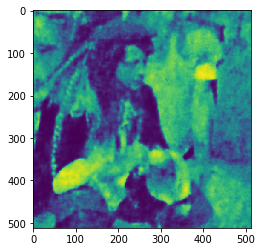

Op time: 30.146663
Iteration 00300  Loss 0.003216  PSNR 24.927350
3


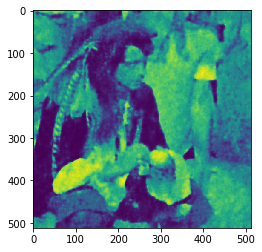

Op time: 40.177483
Iteration 00400  Loss 0.002594  PSNR 25.860726
3


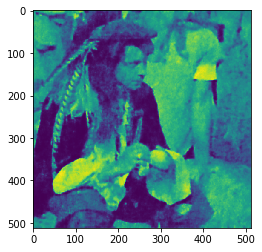

Op time: 49.919097
Iteration 00500  Loss 0.002185  PSNR 26.605091
3


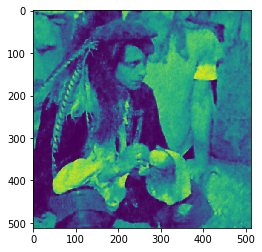

Op time: 59.981348
Iteration 00600  Loss 0.001908  PSNR 27.195184
3


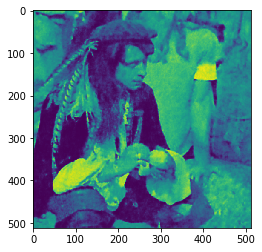

Op time: 70.005118
Iteration 00700  Loss 0.001681  PSNR 27.744822
3


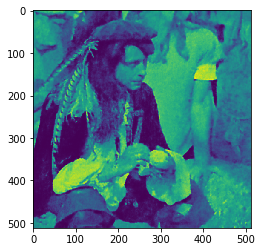

Op time: 80.044245
Iteration 00800  Loss 0.001557  PSNR 28.078193
3


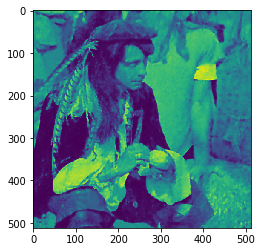

Op time: 89.826969
Iteration 00900  Loss 0.001334  PSNR 28.748448
3


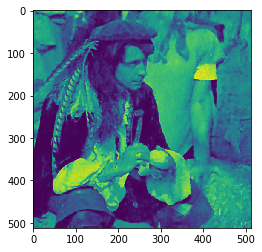

Op time: 99.878404
Iteration 01000  Loss 0.001194  PSNR 29.230096
3


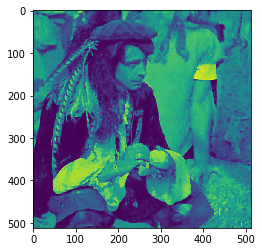

Op time: 109.932530
Iteration 01100  Loss 0.001077  PSNR 29.679288
3


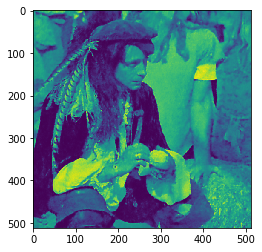

Op time: 119.726529
Iteration 01200  Loss 0.000976  PSNR 30.107252
3


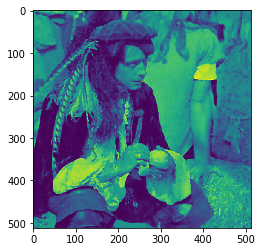

Op time: 129.913126
Iteration 01300  Loss 0.000893  PSNR 30.490746
3


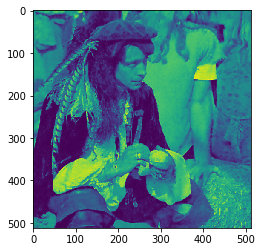

Op time: 139.667018
Iteration 01400  Loss 0.000821  PSNR 30.858067
3


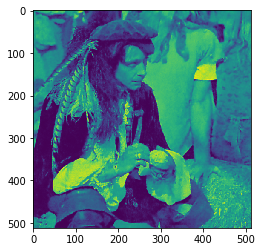

Op time: 149.267648
Iteration 01500  Loss 0.000756  PSNR 31.214923
3


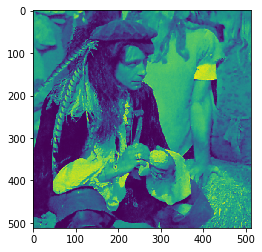

Op time: 158.947731
Iteration 01600  Loss 0.000719  PSNR 31.432403
3


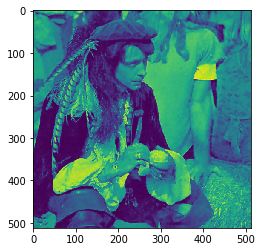

Op time: 168.692336
Iteration 01700  Loss 0.000645  PSNR 31.903715
3


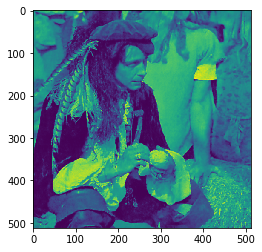

Op time: 178.403362
Iteration 01800  Loss 0.000599  PSNR 32.224378
3


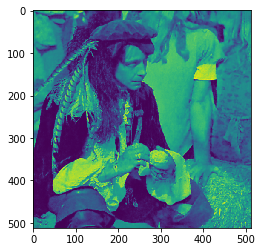

Op time: 188.151122
Iteration 01900  Loss 0.000579  PSNR 32.372075
3


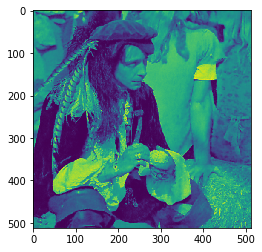

Op time: 198.004771
Iteration 02000  Loss 0.000536  PSNR 32.711138
3


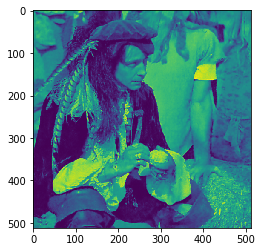

Op time: 207.954709
Iteration 02100  Loss 0.000496  PSNR 33.047449
3


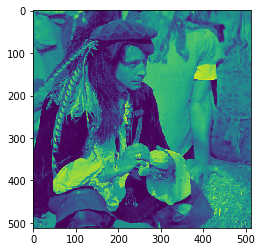

Op time: 217.766307
Iteration 02200  Loss 0.000469  PSNR 33.287485
3


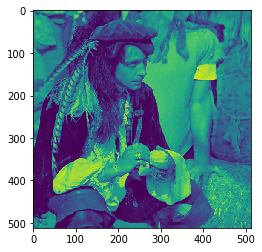

Op time: 227.570385
Iteration 02300  Loss 0.000442  PSNR 33.543979
3


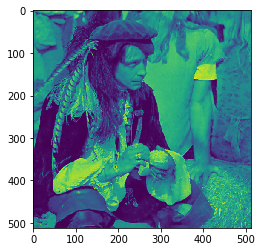

Op time: 237.125177
Iteration 02400  Loss 0.000408  PSNR 33.894973
3


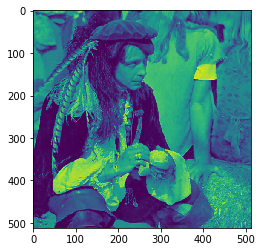

Op time: 246.581574
Iteration 02500  Loss 0.000417  PSNR 33.802235
3


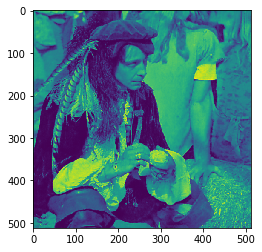

Op time: 256.123581
Iteration 02600  Loss 0.000360  PSNR 34.435021
3


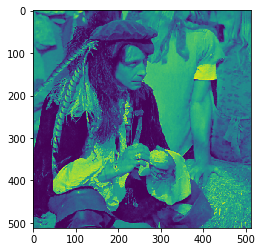

Op time: 265.598680
Iteration 02700  Loss 0.000332  PSNR 34.789622
3


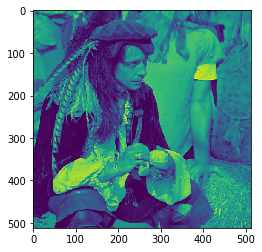

Op time: 274.945217
Iteration 02800  Loss 0.000335  PSNR 34.744582
3


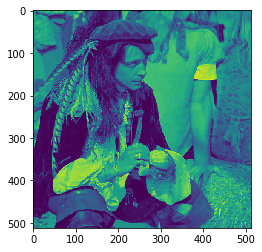

Op time: 284.322432
Iteration 02900  Loss 0.000305  PSNR 35.162465
3


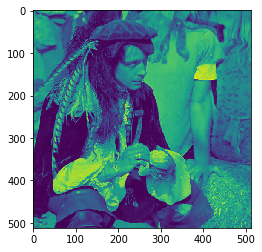

Op time: 293.840973
Iteration 03000  Loss 0.000288  PSNR 35.411746
3


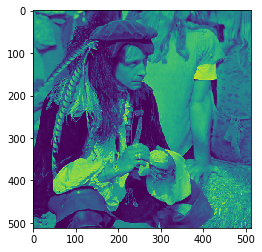

Op time: 303.333044
Iteration 03100  Loss 0.000266  PSNR 35.743325
3


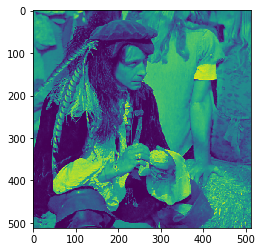

Op time: 312.656168
Iteration 03200  Loss 0.000248  PSNR 36.051879
3


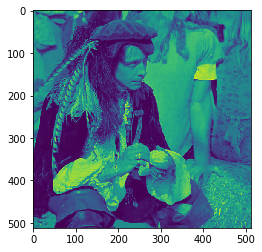

Op time: 321.949923
Iteration 03300  Loss 0.000238  PSNR 36.232116
3


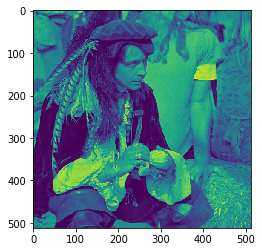

Op time: 331.535390
Iteration 03400  Loss 0.000221  PSNR 36.560289
3


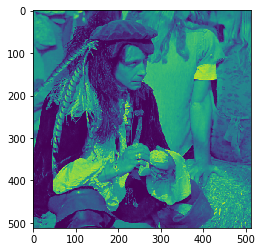

Op time: 340.815075
Iteration 03500  Loss 0.000209  PSNR 36.791969
3


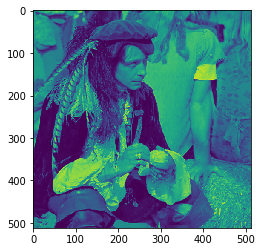

Op time: 350.107140
Iteration 03600  Loss 0.000199  PSNR 37.019673
3


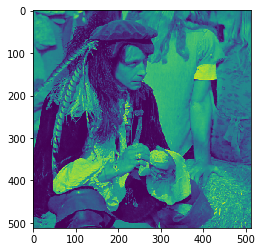

Op time: 359.434600
Iteration 03700  Loss 0.000196  PSNR 37.084883
3


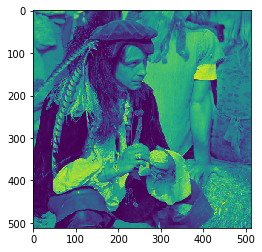

Op time: 369.025929
Iteration 03800  Loss 0.000179  PSNR 37.465900
3


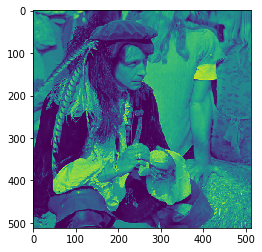

Op time: 378.559152
Iteration 03900  Loss 0.000169  PSNR 37.710819
3


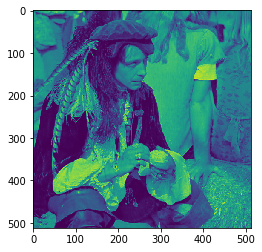

Op time: 388.149787
Iteration 04000  Loss 0.000170  PSNR 37.694671
3


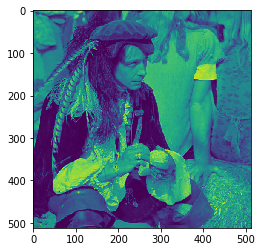

Op time: 397.671075
Iteration 04100  Loss 0.000152  PSNR 38.172698
3


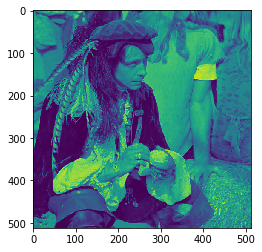

Op time: 407.071116
Iteration 04200  Loss 0.000139  PSNR 38.584816
3


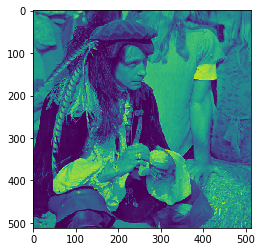

Op time: 416.597770
Iteration 04300  Loss 0.000150  PSNR 38.246255
3


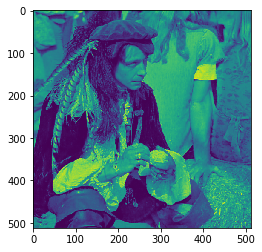

Op time: 426.070215
Iteration 04400  Loss 0.000127  PSNR 38.957702
3


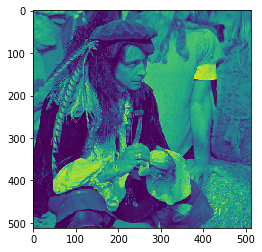

Op time: 435.505192
Iteration 04500  Loss 0.000117  PSNR 39.325120
3


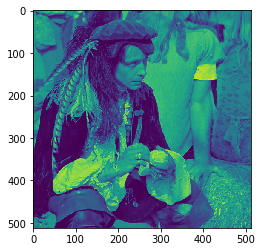

Op time: 444.870257
Iteration 04600  Loss 0.000114  PSNR 39.440509
3


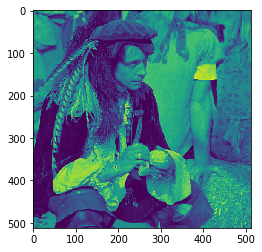

Op time: 454.225262
Iteration 04700  Loss 0.000105  PSNR 39.779935
3


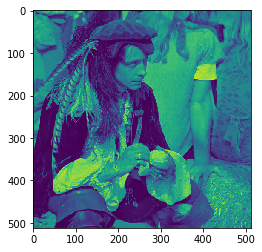

Op time: 463.581753
Iteration 04800  Loss 0.000108  PSNR 39.663672
3


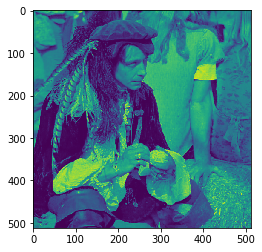

Op time: 473.037181
Iteration 04900  Loss 0.000107  PSNR 39.706508
3


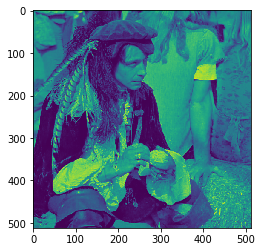

Op time: 482.413888
Iteration 05000  Loss 0.000107  PSNR 39.717898
3


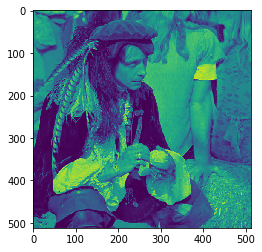

Op time: 491.773189
Iteration 05100  Loss 0.000080  PSNR 40.957156
3


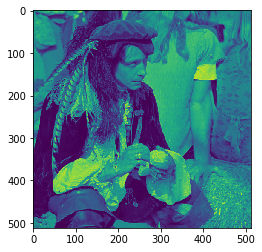

Op time: 501.194418
Iteration 05200  Loss 0.000075  PSNR 41.222230
3


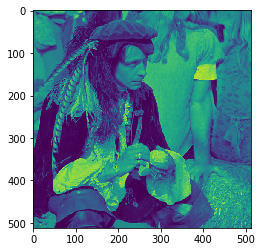

Op time: 510.698657
Iteration 05300  Loss 0.000072  PSNR 41.409149
3


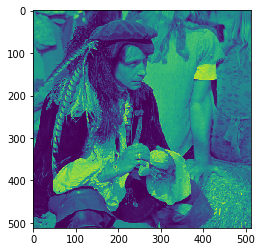

Op time: 520.365121
Iteration 05400  Loss 0.000072  PSNR 41.427864
3


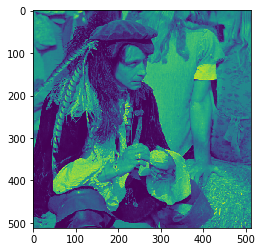

Op time: 529.797489
Iteration 05500  Loss 0.000072  PSNR 41.448284
3


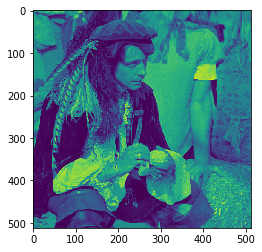

Op time: 539.298291
Iteration 05600  Loss 0.000060  PSNR 42.228840
3


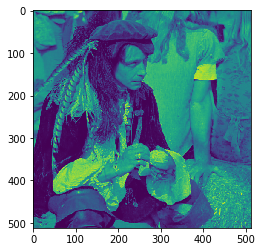

Op time: 548.706913
Iteration 05700  Loss 0.000062  PSNR 42.096054
3


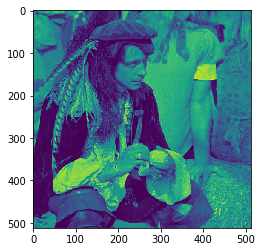

Op time: 558.156265
Iteration 05800  Loss 0.000060  PSNR 42.250479
3


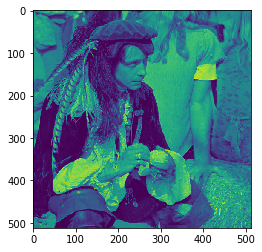

Op time: 567.691369
Iteration 05900  Loss 0.000056  PSNR 42.535487
3


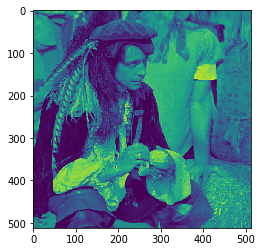

Op time: 577.177720
Iteration 06000  Loss 0.000053  PSNR 42.782401
3


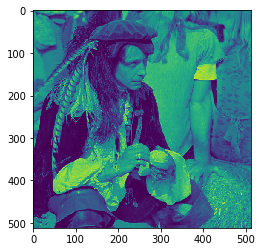

Op time: 577.429644


In [30]:
input_depth = 32
LR = 0.01 
num_iter = 6001
reg_noise_std = 0.03
if len(processed_img.shape)<4:
    c = 1
    w,h = processed_img.shape[1],processed_img.shape[2]
else:
    c = processed_img.shape[1]
    w,h = processed_img.shape[2], processed_img.shape[3]
    

model = skip(input_depth, c, 
               c_down = [128] * 5,
               c_up =   [128] * 5,
               c_skip =    [128] * 5,  
               k_up = 3, k_down = 3, 
               upsample_mode='nearest', k_skip=1).type(dtype)
# print(model)

mse = torch.nn.MSELoss().type(dtype)

net_input = torch.zeros([1, input_depth, w, h])
net_input = net_input.type(dtype)
net_input.uniform_() #net_input.normal_()
net_input *= 0.1           
noise = net_input.detach().clone()
net_input_saved = net_input.detach().clone()

params = [x for x in model.parameters()]
optimizer = torch.optim.Adam(params, lr=LR)
PSNR = []
start = time.time()
for i in range(num_iter):
    optimizer.zero_grad()
    
    net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = model(net_input)

    loss = mse(out * mask, processed_img)
    loss.backward()
    
    optimizer.step()
    PSNR.append(10 * math.log10(1 / loss.item()))   
    if i % 100 == 0:
        print("Op time: %f" % (time.time()-start))
        print('Iteration %05d  Loss %f  PSNR %f' % (i, loss.item(), 10 * math.log10(1 / loss.item())))
        out = out.detach().cpu().numpy()[0]
        plt.figure()
        print(len(out.shape))
        if len(out.shape)<=3:
            plt.imshow(out[0])
        else:
            plt.imshow(out.transpose(1,2,0))
        plt.show()
print("Op time: %f" % (time.time()-start))

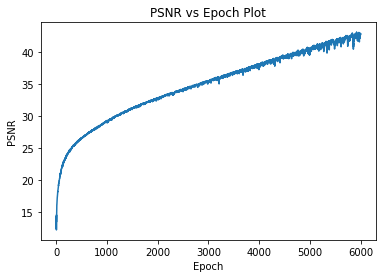

In [31]:
plt.title("PSNR vs Epoch Plot")
plt.xlabel("Epoch")
plt.ylabel("PSNR")
plt.plot(PSNR)

In [32]:
PSNR[-1]

42.782401350379864

In [ ]:
def add_module(self, module):
    self.add_module(str(len(self) + 1), module)
    
torch.nn.Module.add = add_module

class Concat(nn.Module):
    def __init__(self, dim, skip, deeper):
        super(Concat, self).__init__()
        self.dim = dim
        self.layer1 = skip
        self.layer2 = deeper
    def forward(self, input):
        inputs = []
        inputs.append(self.layer1(input))
        inputs.append(self.layer2(input))
        return torch.cat(inputs, dim=self.dim)

def act(activation_method = 'LeakyReLU'):
    if activation_method=='ReLU':
        return nn.ReLU()
    elif activation_method =='LeakyReLU':
        return nn.LeakyReLU(0.2, inplace=True)
    elif activation_method=='sigmoid':
        return nn.Sigmoid()
    else:
        return nn.Tanh()

def conv(in_f, out_f, kernel_size, stride=1): 
    res = []
    res.append(nn.ReflectionPad2d(int((kernel_size - 1) / 2)))
    res.append(nn.Conv2d(in_f, out_f, kernel_size, stride, padding=0))
    return nn.Sequential(*res)

def skip(c_in, c_out, c_down, c_up, c_skip, k_down, k_up, k_skip, upsample_mode, act_fun, ):
    model = nn.Sequential()
    model_tmp = model
    input_depth = c_in
    for i in range(len(c_down)):
        deeper = nn.Sequential()
#         if i == 0:
#             deeper.add(conv(input_depth, c_down[i], k_down, 1))
#         else:
#             deeper.add(conv(input_depth, c_down[i], k_down, 2))
        deeper.add(conv(input_depth, c_down[i], k_down, 2))
        deeper.add(nn.BatchNorm2d(c_down[i]))
        deeper.add(act(act_fun))

        deeper.add(conv(c_down[i], c_down[i], k_down))
        deeper.add(nn.BatchNorm2d(c_down[i]))
        deeper.add(act(act_fun))

#         temp_layers = []
#         temp_layers.append(nn.ReflectionPad2d(int((k_down - 1) / 2)))
#         temp_layers.append(nn.Conv2d(input_depth, c_down[i], k_down, 2))
#         temp_layers.append(nn.BatchNorm2d(c_down[i]))
#         temp_layers.append(act(act_fun))
        
#         temp_layers.append(nn.ReflectionPad2d(int((k_down - 1) / 2)))
#         temp_layers.append(nn.Conv2d(c_down[i], c_down[i], k_down, 1))
#         temp_layers.append(nn.BatchNorm2d(c_down[i]))
#         temp_layers.append(act(act_fun))
        deeper_main = nn.Sequential()
        
        if i < len(c_down)-1:
            deeper.add(deeper_main)
            deeper.add(nn.Upsample(scale_factor=2, mode=upsample_mode))
            if c_skip[i] != 0:
                skip_layers = []
                skip_layers.append(conv(input_depth, c_skip[i], k_skip))
                skip_layers.append(nn.BatchNorm2d(c_skip[i]))
                skip_layers.append(act(act_fun))
                model_tmp.add(Concat(1, nn.Sequential(*skip_layers), deeper))
            else:
                model_tmp.add(deeper)
            model_tmp.add(nn.BatchNorm2d(c_skip[i] + c_up[i + 1] ))
            model_tmp.add(conv(c_skip[i] + c_up[i + 1], c_up[i], k_up, 1))
            
        else:#last layer
            deeper.add(nn.Upsample(scale_factor=2, mode=upsample_mode))
            if c_skip[i] != 0:
                skip_layers = []
                skip_layers.append(conv(input_depth, c_skip[i], k_skip))
                skip_layers.append(nn.BatchNorm2d(c_skip[i]))
                skip_layers.append(act(act_fun))
                model_tmp.add(Concat(1, nn.Sequential(*skip_layers), deeper))
            else:
                model_tmp.add(deeper)
            model_tmp.add(nn.BatchNorm2d(c_skip[i] +c_down[i]))
            model_tmp.add(conv(c_skip[i] + c_down[i], c_up[i], k_up, 1))

        model_tmp.add(nn.BatchNorm2d(c_up[i]))
        model_tmp.add(act(act_fun))
        model_tmp.add(conv(c_up[i], c_up[i], 1))
        model_tmp.add(nn.BatchNorm2d(c_up[i]))
        model_tmp.add(act(act_fun))
        input_depth = c_down[i]
        model_tmp = deeper_main

    model.add(conv(c_up[0], c_out, 1))
    model.add(nn.Sigmoid())

    return model